In [1]:
# !pip install keras-core --upgrade
# !pip install -q keras-nlp
# !pip install seaborn

In [2]:
# pip install transformers

# Import the Libararies

In [3]:
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import keras_core as keras
import keras_nlp
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
print("TensorFlow version:", tf.__version__)
print("Keras version:", keras.__version__)
print("KerasNLP version:", keras_nlp.__version__)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Using TensorFlow backend
TensorFlow version: 2.12.0
Keras version: 0.1.5
KerasNLP version: 0.6.1


# Load the data


In [4]:
train_prompts = pd.read_csv('/kaggle/input/llm-detect-ai-generated-text/train_prompts.csv')
train_essays = pd.read_csv('/kaggle/input/llm-detect-ai-generated-text/train_essays.csv')
test_essays = pd.read_csv('/kaggle/input/llm-detect-ai-generated-text/test_essays.csv')
train_extra = pd.read_csv('/kaggle/input/daigt-v3-train-dataset/train_v3_drcat_01.csv')
train_extra_2 = pd.read_csv('/kaggle/input/daigt-v3-train-dataset/train_v3_drcat_02.csv')

# 🐝 **데이터 분석 및 증강**

In [5]:
df_train_extra=pd.concat([train_extra,train_extra_2],ignore_index=True)


Text(0.5, 1.0, 'Distribution of prompt ID')

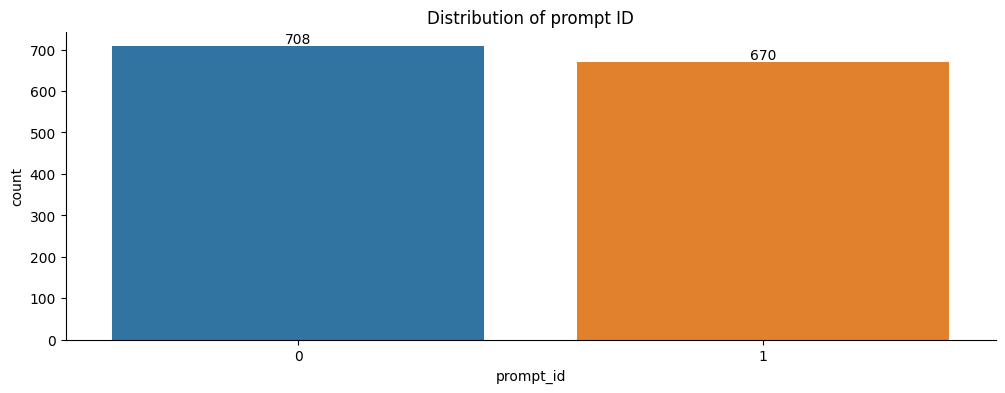

In [6]:
f, ax = plt.subplots(figsize=(12, 4))

sns.despine()
ax = sns.countplot(data=train_essays,
                   x="prompt_id")

abs_values = train_essays['prompt_id'].value_counts().values

ax.bar_label(container=ax.containers[0], labels=abs_values)

ax.set_title("Distribution of prompt ID")

Text(0.5, 1.0, 'Distribution of Generated Text')

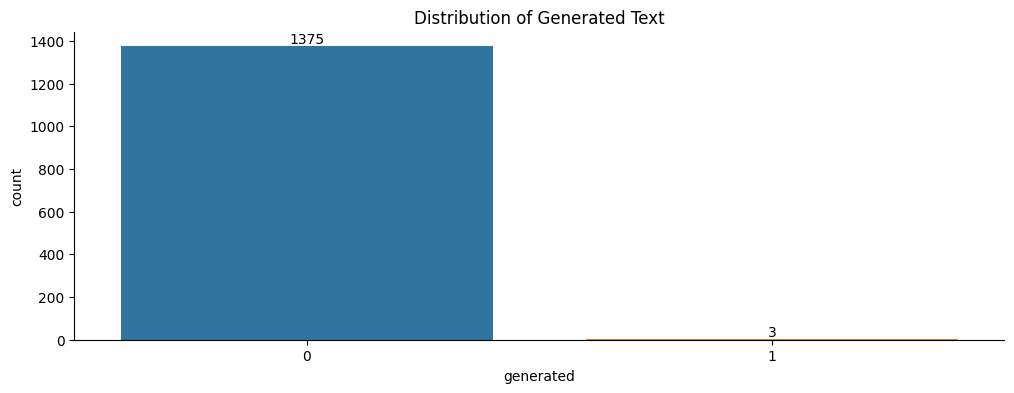

In [7]:
f, ax = plt.subplots(figsize=(12, 4))

sns.despine()
ax = sns.countplot(data=train_essays,
                   x="generated")

abs_values = train_essays['generated'].value_counts().values

ax.bar_label(container=ax.containers[0], labels=abs_values)

ax.set_title("Distribution of Generated Text")

In [8]:
df_train_extra.rename(columns = {"label":"generated"}, inplace=True)

In [9]:
df_train_extra.head()

,text,generated,prompt_name,source,RDizzl3_seven,model
0,Phones\n\nModern humans today are always on th...,0,Phones and driving,persuade_corpus,False,NaN
1,This essay will explain if drivers should or s...,0,Phones and driving,persuade_corpus,False,NaN
2,Driving while the use of cellular devices\n\nT...,0,Phones and driving,persuade_corpus,False,NaN
3,Phones & Driving\n\nDrivers should not be able...,0,Phones and driving,persuade_corpus,False,NaN
4,Cell Phone Operation While Driving\n\nThe abil...,0,Phones and driving,persuade_corpus,False,NaN


Text(0.5, 1.0, 'Distribution of Generated Text')

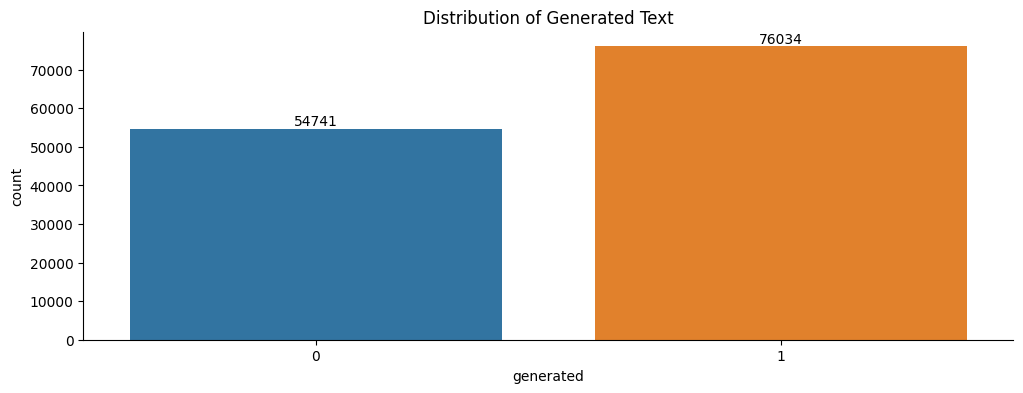

In [10]:
f, ax = plt.subplots(figsize=(12, 4))

sns.despine()
ax = sns.countplot(data=df_train_extra,
                   x="generated")

abs_values = df_train_extra['generated'].value_counts(sort=False).values

ax.bar_label(container=ax.containers[0], labels=abs_values)

ax.set_title("Distribution of Generated Text")

In [11]:
df_train_essays_final = pd.concat([df_train_extra[["text", "generated"]], train_essays[["text", "generated"]]])

df_train_essays_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 132153 entries, 0 to 1377
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   text       132005 non-null  object
 1   generated  132153 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.0+ MB


In [12]:
df_train_essays_final.isna().sum()

text         148
generated      0
dtype: int64

In [13]:
df_train_essays_final.dropna(inplace=True)

In [14]:
df_train_essays_final = df_train_essays_final.drop_duplicates(subset=['text'])

df_train_essays_final.reset_index(drop=True, inplace=True)

Text(0.5, 1.0, 'Distribution of Generated Text')

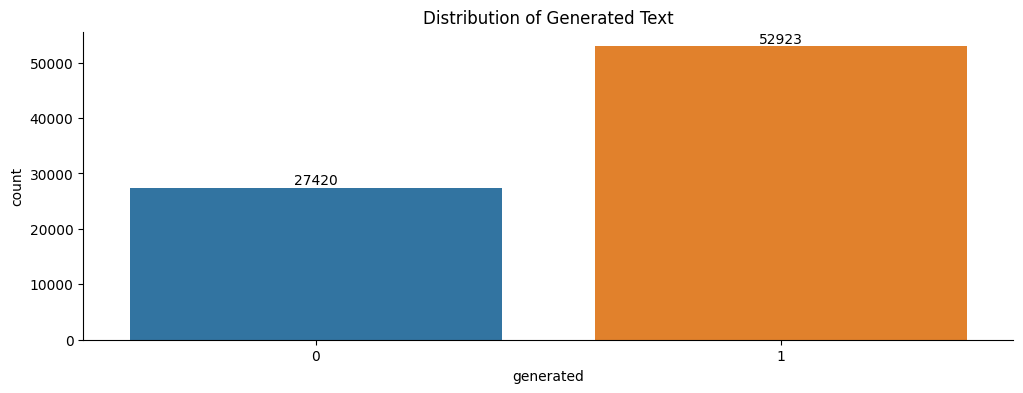

In [15]:
f, ax = plt.subplots(figsize=(12, 4))

sns.despine()
ax = sns.countplot(data=df_train_essays_final,
                   x="generated")


abs_values = df_train_essays_final['generated'].value_counts(sort=False).values
ax.bar_label(container=ax.containers[0], labels=abs_values)
ax.set_title("Distribution of Generated Text")

## 1) generated=0, student 생성 text label 데이터의 감소가 보임__ unbalance 해결 필요
## 2) 전처리된 train set의 text들이 훈련에 적절한 내용을 제대로 포함하고 있는지 확인 필요

# ❓ 오타수정 library 적용 유무 (24.01.10 : X)

In [16]:
# !pip install pyspellchecker

In [17]:
# from spellchecker import SpellChecker

# spell = SpellChecker()
# misspelled = spell.unknown(['let', 'us', 'wlak', 'on', 'the', 'groun'])

# for word in misspelled:
#     print(f'Misspelled word: {word}')
#     print(f'Suggestion: {spell.correction(word)}')


In [18]:
# !pip install textblob

In [19]:
# from textblob import TextBlob

# text = "I havv goood speling"
# blob = TextBlob(text)

# corrected_text = blob.correct()
# print(corrected_text)

In [20]:
# !pip install hunspell

In [21]:
# import hunspell

# # Hunspell 객체 생성 (사전 파일 필요)
# hun = hunspell.HunSpell('/usr/share/hunspell/en_US.dic', '/usr/share/hunspell/en_US.aff')

# # 스펠 체크
# word = "speling"
# if not hun.spell(word):
#     print(f'Misspelled word: {word}')
#     suggestions = hun.suggest(word)
#     print(f'Suggestions: {suggestions}')

# 🐝 **토큰화 진행 (WordPiece vs BPE)** 

## WordPiece

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer
from transformers import BertTokenizer

# BERT 모델에 대한 기본 tokenizer를 사용합니다.
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# BERT의 tokenizer를 사용하여 텍스트를 토큰화하는 함수를 정의합니다.
def bert_tokenize(text):
    # BERT tokenizer로 토큰화하고 토큰 ID를 반환합니다.
    return bert_tokenizer.encode(text, add_special_tokens=True)

# TfidfVectorizer 객체를 생성하고, tokenizer로 위에서 정의한 bert_tokenize 함수를 사용합니다.
tfidf_vectorizer = TfidfVectorizer(tokenizer=bert_tokenize, ngram_range=(1, 2))

# 트레이닝 데이터에 대해 TF-IDF 벡터화를 수행합니다.
X_train_tfidf = tfidf_vectorizer.fit_transform(df_train_essays_final['text'])

# 테스트 데이터에 대해 TF-IDF 벡터화를 수행합니다.
X_test_tfidf = tfidf_vectorizer.transform(test_essays['text'])

OSError: Can't load tokenizer for 'bert-base-uncased'. If you were trying to load it from 'https://huggingface.co/models', make sure you don't have a local directory with the same name. Otherwise, make sure 'bert-base-uncased' is the correct path to a directory containing all relevant files for a BertTokenizer tokenizer.

In [ ]:
tf_train.shape

In [ ]:
pd.DataFrame(tf_train).head

In [ ]:
dense_tf_train = tf_train.todense()
df_tf_train = pd.DataFrame(dense_tf_train)
df_tf_train.describe()

===============================================

## BPE

In [32]:
test_essays.text.values

array(['Aaa bbb ccc.', 'Bbb ccc ddd.', 'CCC ddd eee.'], dtype=object)

In [33]:
LOWERCASE = False
VOCAB_SIZE = 30522

In [34]:
import sys
import gc

import pandas as pd
from sklearn.model_selection import StratifiedKFold
import numpy as np
from sklearn.metrics import roc_auc_score
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer

from tokenizers import (
    decoders,
    models,
    normalizers,
    pre_tokenizers,
    processors,
    trainers,
    Tokenizer,
)

from datasets import Dataset
from tqdm.auto import tqdm
from transformers import PreTrainedTokenizerFast

from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import VotingClassifier

In [35]:
# Creating Byte-Pair Encoding tokenizer
# 어휘집에 없는 단어는 UNK 토큰화
raw_tokenizer = Tokenizer(models.BPE(unk_token="[UNK]"))


# 소문자변환 및 유니코드 문자 정규화, 초기 문자열 byte 수준 분해
raw_tokenizer.normalizer = normalizers.Sequence([normalizers.NFC()] + [normalizers.Lowercase()] if LOWERCASE else [])
raw_tokenizer.pre_tokenizer = pre_tokenizers.ByteLevel()


# train set에 맞는 특수 토크나이징 설정 및 훈련
# 파라미터, 어휘집크기 30522__일단 지정
# 
special_tokens = ["[UNK]", "[PAD]", "[CLS]", "[SEP]", "[MASK]"]
trainer = trainers.BpeTrainer(vocab_size=VOCAB_SIZE, special_tokens=special_tokens)



# df를 huggingface 데이터셋으로 준비, 1000개 단위씩 반복처리
dataset = Dataset.from_pandas(test_essays[['text']])

def train_corp_iter():
    """
    A generator function for iterating over a dataset in chunks.
    """    
    for i in range(0, len(dataset), 1000):
        yield dataset[i : i + 1000]["text"]

        
        
# BPE 토크나이저 훈련 진행코드, 특수 토큰도 함께 부여
raw_tokenizer.train_from_iterator(train_corp_iter(), trainer=trainer)

tokenizer = PreTrainedTokenizerFast(
    tokenizer_object=raw_tokenizer,
    unk_token="[UNK]",
    pad_token="[PAD]",
    cls_token="[CLS]",
    sep_token="[SEP]",
    mask_token="[MASK]",
)


# 토큰화 진행, tqdm으로 진행도 시각화

tokenized_texts_test = []

# Tokenize test set with new tokenizer
for text in tqdm(test_essays['text'].tolist()):
    tokenized_texts_test.append(tokenizer.tokenize(text))


# Tokenize train set
tokenized_texts_train = []

for text in tqdm(df_train_essays_final['text'].tolist()):
    tokenized_texts_train.append(tokenizer.tokenize(text))

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/80343 [00:00<?, ?it/s]

## BERT 토크나이저 가 아닌
## BPE 토크나이저를 코드에 적용한 이유

###  (wordpiece(BERT기반)와 BPE(GPT기반) 성능 비교)

In [36]:
tokenized_texts_test[1]

['ĠBbb', 'Ġccc', 'Ġddd', '.']

In [37]:
def dummy(text):
    """
    A dummy function to use as tokenizer for TfidfVectorizer. It returns the text as it is since we already tokenized it.
    """
    return text

In [38]:
# Fitting TfidfVectoizer on test set

vectorizer = TfidfVectorizer(ngram_range=(3, 5), lowercase=False, sublinear_tf=True, analyzer = 'word',
    tokenizer = dummy,
    preprocessor = dummy,
    token_pattern = None, strip_accents='unicode'
                            )

vectorizer.fit(tokenized_texts_test)

# Getting vocab
vocab = vectorizer.vocabulary_

print(vocab)


# Here we fit our vectorizer on train set but this time we use vocabulary from test fit.
vectorizer = TfidfVectorizer(ngram_range=(3, 5), lowercase=False, sublinear_tf=True, vocabulary=vocab,
                            analyzer = 'word',
                            tokenizer = dummy,
                            preprocessor = dummy,
                            token_pattern = None, strip_accents='unicode'
                            )

tf_train = vectorizer.fit_transform(tokenized_texts_train)
tf_test = vectorizer.transform(tokenized_texts_test)

del vectorizer
gc.collect()

{'ĠAaa Ġbbb Ġccc': 0, 'Ġbbb Ġccc .': 6, 'ĠAaa Ġbbb Ġccc .': 1, 'ĠBbb Ġccc Ġddd': 2, 'Ġccc Ġddd .': 7, 'ĠBbb Ġccc Ġddd .': 3, 'ĠCCC Ġddd Ġeee': 4, 'Ġddd Ġeee .': 8, 'ĠCCC Ġddd Ġeee .': 5}


23

In [40]:
y_train = df_train_essays_final['generated'].values

In [41]:
tf_train

<80343x9 sparse matrix of type '<class 'numpy.float64'>'
	with 0 stored elements in Compressed Sparse Row format>

In [42]:
tf_train.shape

(80343, 9)

In [43]:
tf_test.shape

(3, 9)

In [46]:
pd.DataFrame(tf_train).head

<bound method NDFrame.head of       0 
0       
1       
2       
3       
4       
...   ..
80338   
80339   
80340   
80341   
80342   

[80343 rows x 1 columns]>

In [52]:
dense_tf_train = tf_train.todense()
df_tf_train = pd.DataFrame(dense_tf_train)
df_tf_train.describe()

,0,1,2,3,4,5,6,7,8
count,80343.0,80343.0,80343.0,80343.0,80343.0,80343.0,80343.0,80343.0,80343.0
mean,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


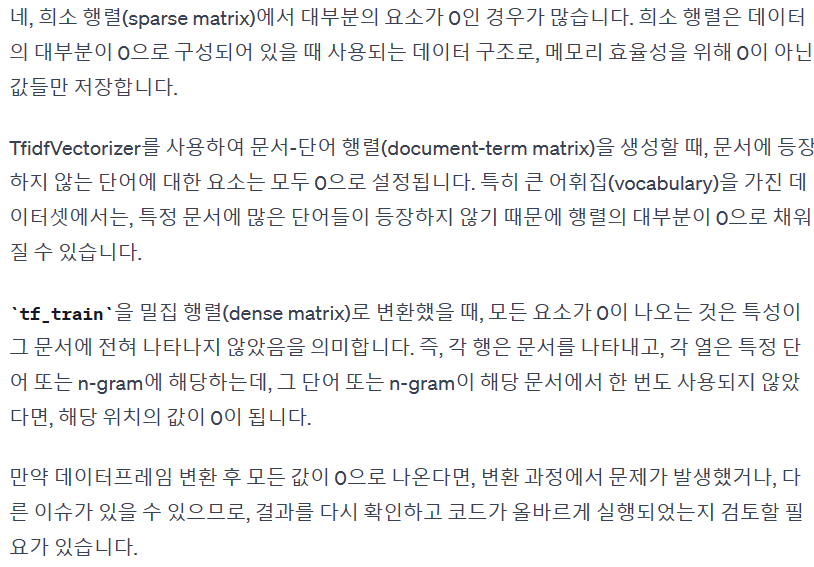

==============================================

# 🐝 **모델학습 진행**

# A basic classifier pipeline with minimal tweaks from public notebooks.

In [ ]:
bayes_model = MultinomialNB(alpha=0.02)
sgd_model = SGDClassifier(max_iter=8000, tol=1e-4, loss="modified_huber")


ensemble = VotingClassifier(estimators=[('sgd', sgd_model), ('nb', bayes_model)],
                            weights=[0.7, 0.3], voting='soft', n_jobs=-1)
ensemble.fit(tf_train, y_train)


gc.collect()

In [ ]:
final_preds = ensemble.predict_proba(tf_test)[:,1]

In [ ]:
sub['generated'] = final_preds
sub.to_csv('submission.csv', index=False)
sub

# 🐝 RoBERTa 코드 적용

# 🐝 RWKV 모델 적용

# 🐝 RAG 모듈 적용

# 🐝 text 데이터 증강기법 __ unbalance 해소

# 🐝 난독화 대처방법 고찰
https://www.kaggle.com/competitions/llm-detect-ai-generated-text/discussion/461292
### 그 중 난독화, 노이즈 대처법 하나
https://www.kaggle.com/code/sjorslockhorst/authentigpt-trial-w-roberta!

# 👿 연습장

In [16]:
# # We choose 512 because it's the limit of DistilBert
# SEQ_LENGTH = 512

# # Use a shorter sequence length.
# preprocessor = keras_nlp.models.DistilBertPreprocessor.from_preset(
#     "distil_bert_base_en_uncased",
#     sequence_length=SEQ_LENGTH,
# )

# # Pretrained classifier.
# classifier = keras_nlp.models.DistilBertClassifier.from_preset(
#     "distil_bert_base_en_uncased",
#     num_classes=2,
#     activation=None,
#     preprocessor=preprocessor,
# )

# # Re-compile (e.g., with a new learning rate)
# classifier.compile(
#     loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#     optimizer=keras.optimizers.Adam(5e-4),
#     metrics=[
#         keras.metrics.SparseCategoricalAccuracy()
#    ]
# )
    

# # Access backbone programmatically (e.g., to change `trainable`).
# classifier.backbone.trainable = False


# classifier.summary()

Exception: URL fetch failure on https://storage.googleapis.com/keras-nlp/models/distil_bert_base_en_uncased/v1/vocab.txt: None -- [Errno -3] Temporary failure in name resolution

In [ ]:
# Split the dataset into train and test sets
from sklearn.model_selection import train_test_split
X_temp, X_test, y_temp, y_test = train_test_split(df_train_essays_final["text"],
                                                    df_train_essays_final["generated"],
                                                    test_size=0.30,
                                                    random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp,
                                                  y_temp,
                                                  test_size=0.20,
                                                  random_state=42)


In [ ]:
# Fit
classifier.fit(x=X_train, 
               y=y_train,
               validation_data=(X_test, y_test),
               epochs=2,
               batch_size=64
              )

In [ ]:
def displayConfusionMatrix(y_true, y_pred, dataset):
    disp = ConfusionMatrixDisplay.from_predictions(
        y_true,
        np.argmax(y_pred, axis=1),
        display_labels=["Human","AI"],
        cmap=plt.cm.Blues
    )
    tn, fp, fn, tp = confusion_matrix(y_true, np.argmax(y_pred, axis=1)).ravel()
    f1_score = tp / (tp+((fn+fp)/2))
    disp.ax_.set_title("Confusion Matrix on " + dataset + " Dataset -- F1 Score: " + str(f1_score.round(2)))

In [ ]:
y_pred_test = classifier.predict(X_test)

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
displayConfusionMatrix(y_test, y_pred_test,  "Testing")

In [ ]:
y_pred_val = classifier.predict(X_val)

In [ ]:
displayConfusionMatrix(y_val, y_pred_val,  "validation")